# This notebook contains:
* Code investigating whether there are any signals from the Willis Island land surface in the rainfall retrievals
* Original function of how I opened radar data
* Willis island missing data investigation

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
from numpy import s_
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from collections import defaultdict
import metpy
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
# define function to open radar data JFMA 2012-2022; cairns=19; townsville=73; willis=41
def open_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return xr.open_mfdataset(files_list, engine="h5netcdf", chunks="auto") #={'time':-1})

In [3]:
ds_radar_W = open_radar_ds("41")

0.3.0


In [4]:
ds_radar_W = ds_radar_W.persist()

In [203]:
def hov_diurnal_no_winds(ds,lon1,lon2):
    quality_check = ds.isfile[ds.isfile.values>0]
    rr = ds.rainrate.isel(x=slice(lon1,lon2)).where(quality_check)
    hourly_grouped_rr = rr.groupby(rr.time.dt.hour)
    diurnal_rr_all = []
    for hours in np.arange(0,24,1):
        rr_mean = hourly_grouped_rr[hours].mean(dim=['time','y','x'],skipna=True) 
        print(hours)
        diurnal_rr_all.append(rr_mean.values) 
    return diurnal_rr_all

In [172]:
willis_island_edge = hov_diurnal_no_winds(ds_radar_W,150,225)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [173]:
willis_radar_boundary = hov_diurnal_no_winds(ds_radar_W,225,300)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [177]:
willis_edge_aest = np.roll(willis_island_edge,shift=10)
willis_boundary_aest = np.roll(willis_radar_boundary,shift=10)

In [175]:
willis_edge=[]
willis_boundary = []
for i in np.arange(0,24,1):
    willis_edge.append(willis_edge_aest[i])
    willis_boundary.append(willis_boundary_aest[i])

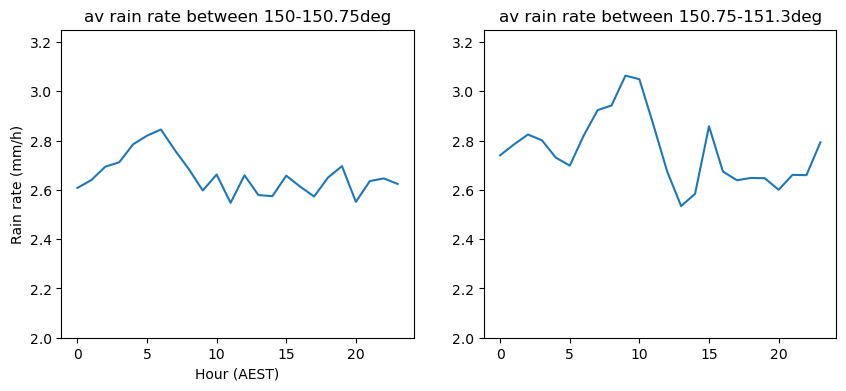

In [192]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot(willis_edge_aest)
ax[1].plot(willis_boundary_aest)
ax[0].set_ylim(2,3.25)
ax[1].set_ylim(2,3.25)
ax[0].set_title("av rain rate between 150-150.75deg")
ax[1].set_title("av rain rate between 150.75-151.3deg")
ax[0].set_xlabel("Hour (AEST)")
ax[0].set_ylabel('Rain rate (mm/h)');

In [195]:
# len(willis_edge_aest[0])
nan_edge=[]
nan_boundary=[]
for hours in np.arange(0,24,1):
    nans = np.isnan(willis_edge_aest[hours]).sum()
    nan_radar_boundary = np.isnan(willis_boundary_aest[hours]).sum()
    nan_edge.append(nans)
    nan_boundary.append(nan_radar_boundary)

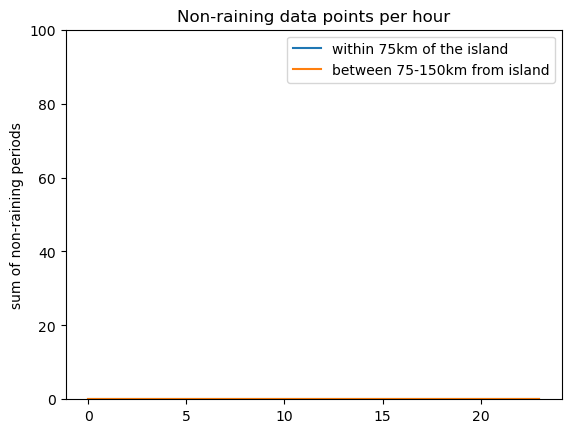

In [202]:
plt.plot(nan_edge,label='within 75km of the island')
plt.plot(nan_boundary,label='between 75-150km from island')
plt.ylim(0,100)
plt.title('Non-raining data points per hour')
plt.legend()
plt.ylabel('sum of non-raining periods');

# willis island investigation

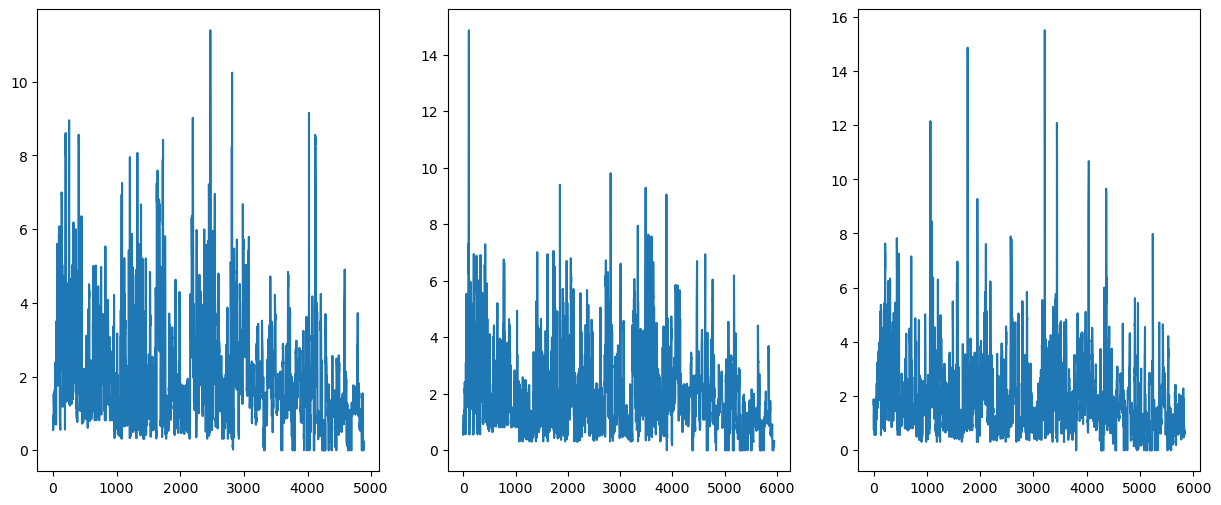

In [24]:
fig,ax = plt.subplots(1,3, figsize=[15,6])
fig.patch.set_facecolor('white')
data = ds_radar_W.rainrate
valid_dps = ds_radar_W.rainrate.mean(dim='time')
mask = ~valid_dps.isnull()
masked = data.where(mask)
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
rr_5 = hourly_rr[5]
rr_6 = hourly_rr[6]
rr_11 = hourly_rr[11]

invalid_points5 = hourly_rr[5].mean(dim=['x','y']).isnull()
invalid_points6 = hourly_rr[6].mean(dim=['x','y']).isnull()
invalid_points11 = hourly_rr[11].mean(dim=['x','y']).isnull()
invalid_points11 = hourly_rr[12].mean(dim=['x','y']).isnull()

invalid_window5 = invalid_points5.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered5 = rr_5.sel(time=~invalid_window5)
invalid_window6 = invalid_points6.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered6 = rr_6.sel(time=~invalid_window6)
invalid_window11 = invalid_points11.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered11 = rr_11.sel(time=~invalid_window11)
invalid_window12 = invalid_points12.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered12 = rr_11.sel(time=~invalid_window12)

ax[0].plot(dataset_filtered5.mean(dim=['x','y']))
ax[1].plot(dataset_filtered6.mean(dim=['x','y']))
ax[2].plot(dataset_filtered11.mean(dim=['x','y']))

CPU times: user 15min 48s, sys: 4min 20s, total: 20min 8s
Wall time: 1min 21s


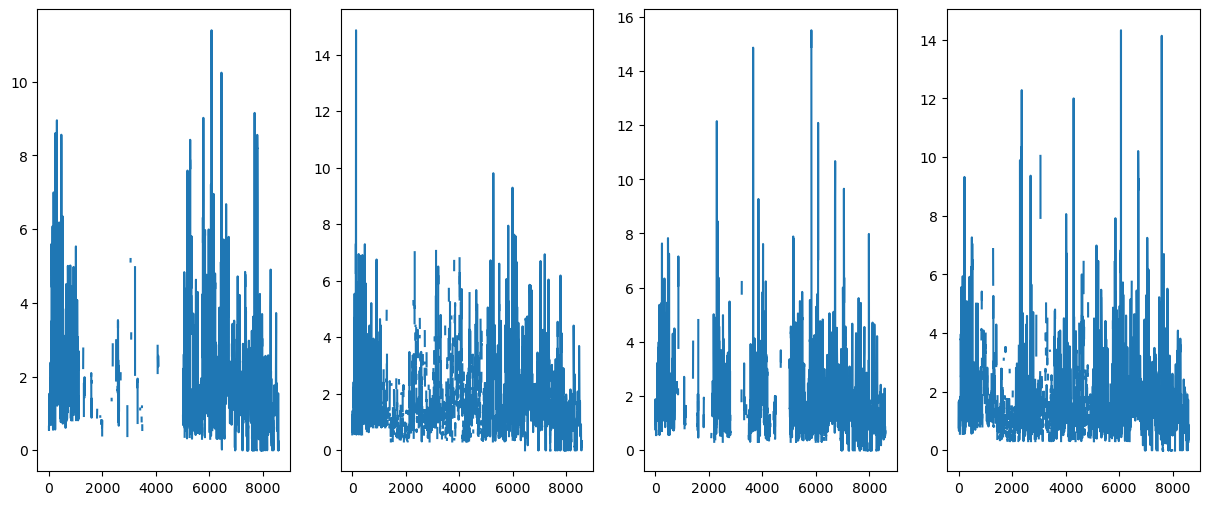

In [104]:
%%time
fig,ax = plt.subplots(1,4, figsize=[15,6])
fig.patch.set_facecolor('white')
valid_dps = ds_radar_W.rainrate.mean(dim='time')
mask = ~valid_dps.isnull()
masked = ds_radar_W.rainrate.where(mask)
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
ax[0].plot(hourly_rr[5].mean(dim=['x','y']))
ax[1].plot(hourly_rr[6].mean(dim=['x','y']))
ax[2].plot(hourly_rr[11].mean(dim=['x','y']))
ax[3].plot(hourly_rr[12].mean(dim=['x','y']))

CPU times: user 15min 37s, sys: 4min 16s, total: 19min 53s
Wall time: 1min 20s


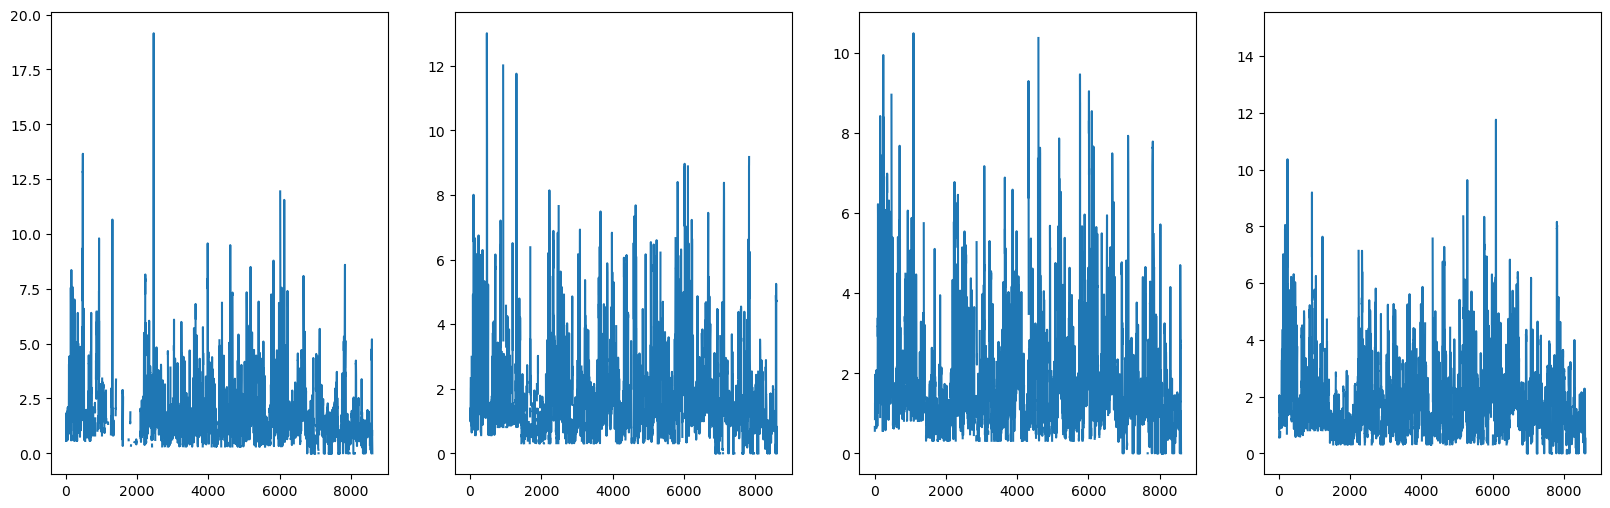

In [106]:
%%time
fig,ax = plt.subplots(1,4, figsize=[20,6])
fig.patch.set_facecolor('white')
valid_dps = ds_radar_W.rainrate.mean(dim='time')
mask = ~valid_dps.isnull()
masked = ds_radar_W.rainrate.where(mask)
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
ax[0].plot(hourly_rr[0].mean(dim=['x','y']))
ax[1].plot(hourly_rr[1].mean(dim=['x','y']))
ax[2].plot(hourly_rr[2].mean(dim=['x','y']))
ax[3].plot(hourly_rr[3].mean(dim=['x','y']))

In [130]:
# plt.scatter(ds_radar_W.isfile.values,len(ds_radar_W.isfile.values))

mask = ds_radar_W.isfile[ds_radar_W.isfile.values>0]
masked = ds_radar_W.rainrate.where(mask)
# masked.plot()

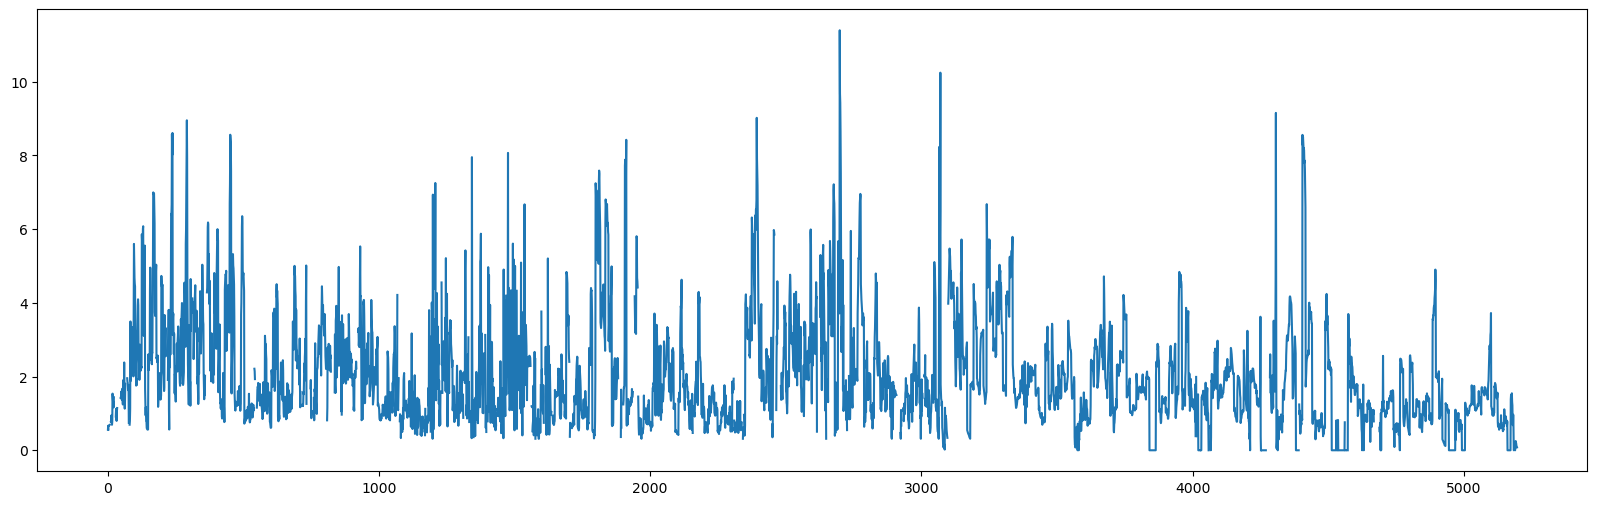

In [132]:
fig,ax = plt.subplots(1,1, figsize=[20,6])
fig.patch.set_facecolor('white')
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
ax.plot(hourly_rr[5].mean(dim=['x','y']))